In [2]:
import os, sys
import numpy as np
import healpy as hp
import pandas as pd
import h5py
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# os.system('module load texlive/2022')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size"  : 13
})

matplotlib.rcParams.update({'font.size': 15})

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rc('text.latex', preamble=r'\usepackage{/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/apjfonts}')
        
#plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['axes.facecolor']   = 'w'
plt.rcParams['figure.facecolor'] = 'w'


kidscol = '#9CC363'    # light olive
descol  = 'chocolate'  # dark orange
hsccol  = '#5A8BAF'    # lightpurple

In [3]:
# Figure 2 shows various quantities of the shear catalogs post-processing.

# catalogs can be found here at NERSC:
desy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/shear_catalog_desy3_unmasked_withfakez_v2.h5'
hscy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/txpipe_allfield_shear.h5'
kidspath  = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/shear_catalog_kids1000_v2.hdf5'

# We run TXPipe's SourceSelector
# and load the processed catalogs

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/desy3a/outputs/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    R_total_2d = f["response/R_S_2d"][:] + f["response/R_gamma_mean_2d"][:]
    with h5py.File(desy3path,'r') as g:
        h = g['shear']
        des_g1   = h["mcal_g1"][:][mask] 
        des_g2   = h["mcal_g1"][:][mask]
        des_psfT = h["mcal_psf_T_mean"][:][mask]
        des_T    = h["mcal_T"][:][mask]
        des_snr  = h["mcal_s2n"][:][mask]
        # calibrate:
        des_g1,des_g2 = np.linalg.inv(R_total_2d) @ [des_g1,des_g2]

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs/shearsys//shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1  
    R = f['response/R_mean_2d'][0]
    K = f['response/K_2d'][0]
    with h5py.File(hscy3path,'r') as g: 
        h = g['shear']
        hsc_g1   = h['g1'][:][mask]
        hsc_g2   = h['g2'][:][mask]
        hsc_psfT = h['psf_T_mean'][:][mask]
        hsc_T    = h['T'][:][mask]
        hsc_snr  = h['s2n'][:][mask]
        # calibrate:
        hsc_g1 = ((hsc_g1 / (2 * R) - h['c1'][:][mask]) / (1 + K) - h['aselepsf1'][:][mask])/(1+h['msel'][:][mask])
        hsc_g2 = ((hsc_g2 / (2 * R) - h['c2'][:][mask]) / (1 + K) - h['aselepsf2'][:][mask])/(1+h['msel'][:][mask])

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/kids/outputs/meansubperfield/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    c_n = f["response/C_2d_N"][:] 
    c_s = f["response/C_2d_S"][:]
    K   = f["response/K_2d"][:] 
    with h5py.File(kidspath,'r') as g:
        h = g['shear']
        kids_g1   = h['g1'][:][mask]
        kids_g2   = h['g2'][:][mask]
        kids_psfT = h['psf_T_mean'][:][mask]
        kids_T    = h['T'][:][mask]
        kids_snr  = h['s2n'][:][mask]
        # additive bias removal:
        Nmask = h['dec'][:][mask] > -25.0
        Smask = h['dec'][:][mask] <= -25.0

        kids_g1[Nmask] = (kids_g1[Nmask] - c_n[0]) / (1 + K)
        kids_g1[Smask] = (kids_g1[Smask] - c_s[0]) / (1 + K)
        kids_g2[Nmask] = (kids_g2[Nmask] - c_n[1]) / (1 + K)
        kids_g2[Smask] = (kids_g2[Smask] - c_s[1]) / (1 + K)
        

<Figure size 640x480 with 0 Axes>

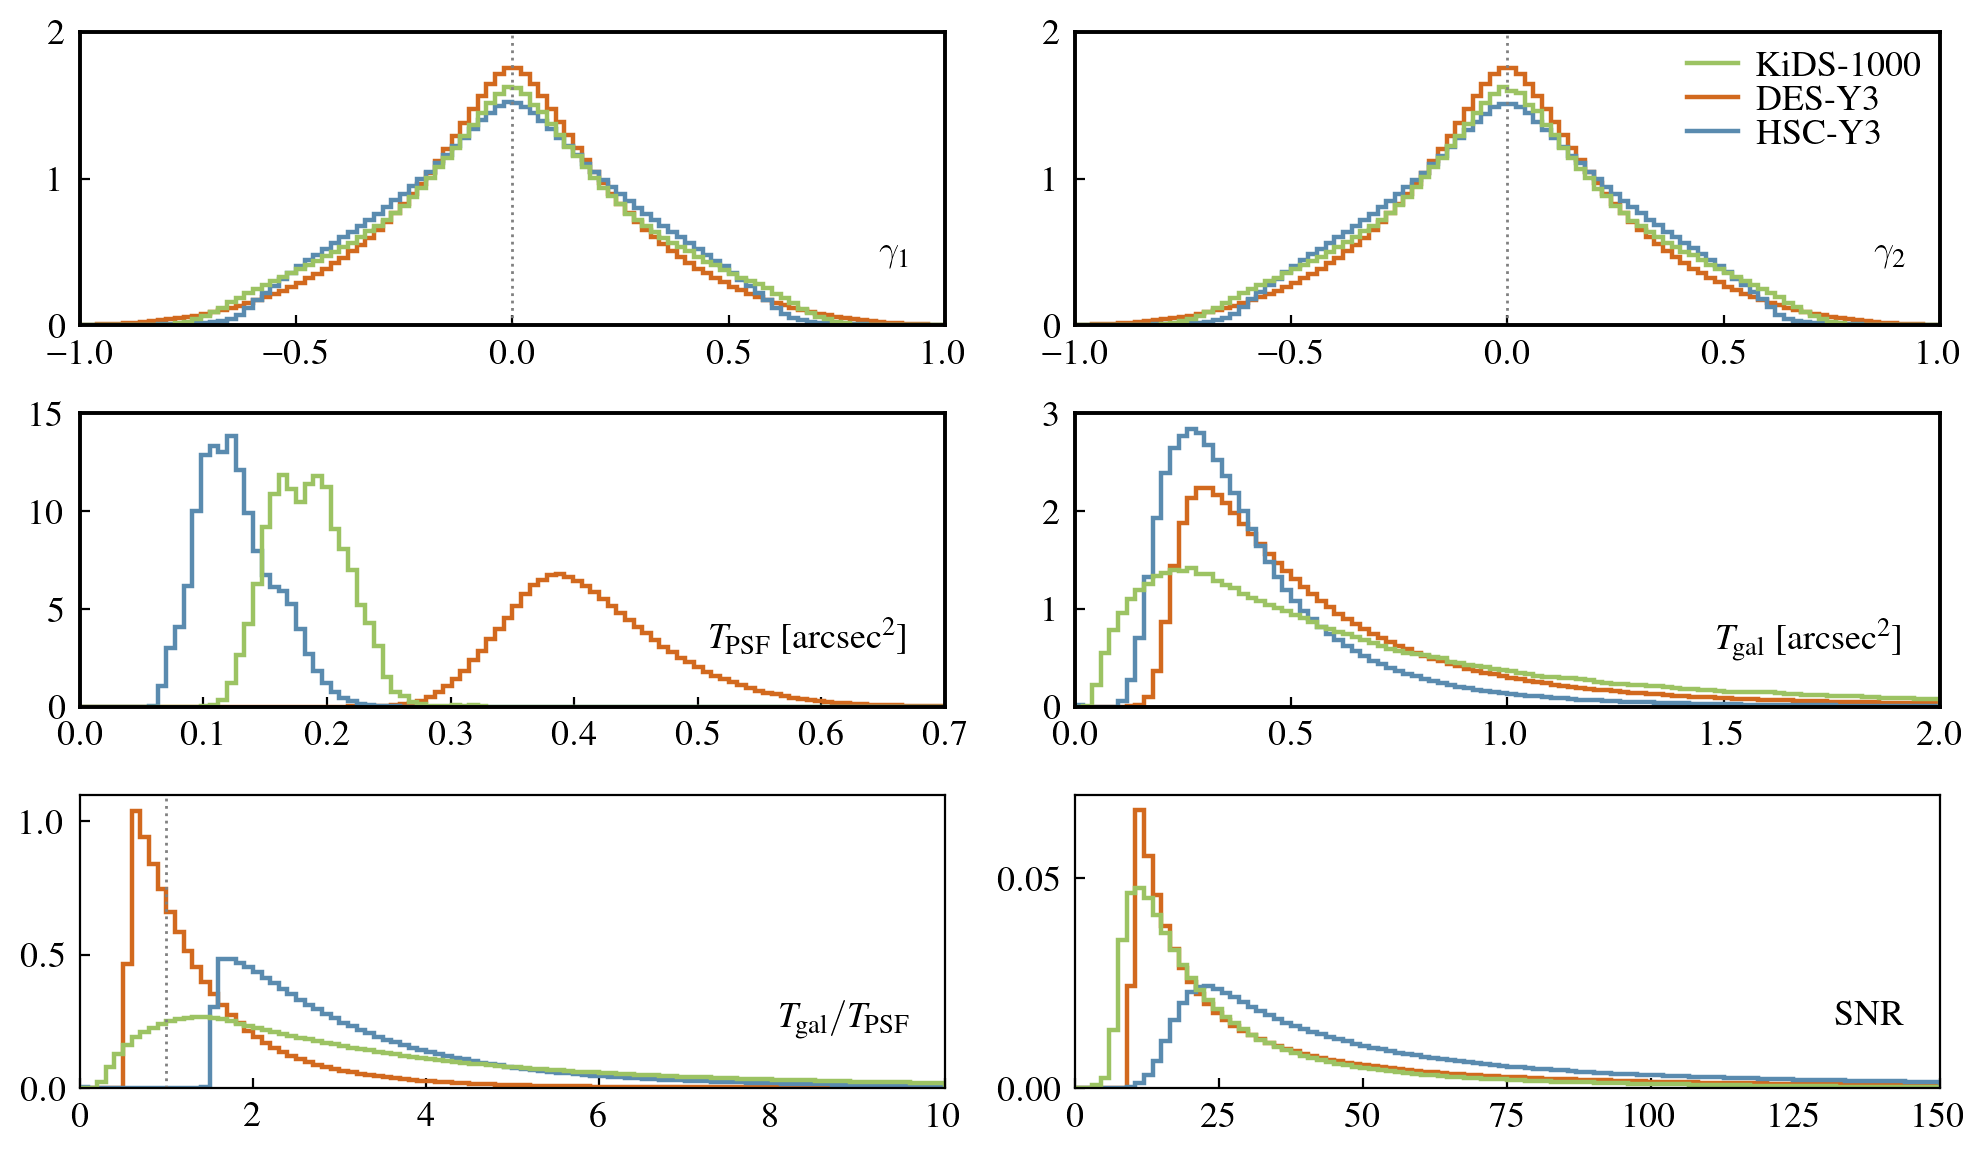

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams.update({'font.size': 13})

plt.clf()
fig = plt.figure(figsize=(10,6),dpi=100)
gs  = gridspec.GridSpec(3, 2, top=0.98, right=0.98, left=0.05, bottom=0.1,hspace=0.3, wspace=0.15)

ax0 = plt.subplot(gs[0])
ax0.hist(des_g1,bins=100,range=[-1,1],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax0.hist(hsc_g1,bins=100,range=[-1,1],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax0.hist(kids_g1,bins=100,range=[-1,1],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax0.text(0.96,0.3,r'$\gamma_{1}$',transform=ax0.transAxes,ha='right',va='top',size=13)
ax0.tick_params(axis="both",which='both',direction="in")
ax0.set_ylim(0,2)
ax0.set_xlim(-1,1)
ax0.plot([0,0],[0,2], color='grey', lw=1, ls=':')
ax0.tick_params(axis='both', which='major', pad=5)
ax0.set_yticks([0,1,2])

  
ax1 = plt.subplot(gs[1])
ax1.hist(des_g2,bins=100,range=[-1,1],histtype='step',color=descol,density=True,lw=1.6)
ax1.hist(-1*hsc_g2,bins=100,range=[-1,1],histtype='step',color=hsccol,density=True,lw=1.6)
ax1.hist(kids_g2,bins=100,range=[-1,1],histtype='step',color=kidscol,density=True,lw=1.6)
ax1.text(0.96,0.3,r'$\gamma_{2}$',transform=ax1.transAxes,ha='right',va='top',size=13)
ax1.tick_params(axis="both",which='both',direction="in")
ax1.plot(np.linspace(-1000,-1001,3),color=kidscol,lw=1.6,label='KiDS-1000')
ax1.plot(np.linspace(-1000,-1001,3),color=descol,lw=1.6,label='DES-Y3')
ax1.plot(np.linspace(-1000,-1001,3),color=hsccol,lw=1.6,label='HSC-Y3')

ax1.legend(frameon=False,loc = 'upper right', labelspacing=0.03,ncol=1,handletextpad=0.5,columnspacing=0.2,handlelength=1.4,borderaxespad=0.1)
ax1.set_ylim(0,2)
ax1.set_xlim(-1,1)
ax1.plot([0,0],[0,2], color='grey', lw=1, ls=':')
ax1.tick_params(axis='both', which='major', pad=5)
ax1.set_yticks([0,1,2])


ax2 = plt.subplot(gs[2])
ax2.hist(des_psfT,bins=100,range=[0,0.7],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax2.hist(hsc_psfT,bins=100,range=[0,0.7],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax2.hist(kids_psfT,bins=100,range=[0,0.7],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax2.text(0.96,0.3,r'$T_{\rm PSF}$ [arcsec$^2$]',transform=ax2.transAxes,ha='right',va='top',size=13)
ax2.tick_params(axis="both",which='both',direction="in")
ax2.set_ylim(0,15)
ax2.set_xlim(0,0.7)
ax2.tick_params(axis='both', which='major', pad=5)

ax3 = plt.subplot(gs[3])
ax3.hist(des_T,bins=100,range=[0,2],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax3.hist(hsc_T,bins=100,range=[0,2],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax3.hist(kids_T,bins=100,range=[0,2],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax3.text(0.96,0.3,r'$T_{\rm gal}$ [arcsec$^2$]',transform=ax3.transAxes,ha='right',va='top',size=13)
ax3.tick_params(axis="both",which='both',direction="in")
ax3.set_ylim(0,3)
ax3.set_xlim(0,2)
ax3.tick_params(axis='both', which='major', pad=5)
  
ax4 = plt.subplot(gs[4])
ax4.hist(des_T/des_psfT,bins=100,range=[0,10],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax4.hist(hsc_T/hsc_psfT,bins=100,range=[0,10],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax4.hist(kids_T/kids_psfT,bins=100,range=[0,10],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax4.text(0.96,0.3,r'$T_{\rm gal}/T_{\rm PSF}$',transform=ax4.transAxes,ha='right',va='top',size=13)
ax4.tick_params(axis="both",which='both',direction="in")
ax4.set_ylim(0,1.1)
ax4.set_xlim(0,10)
ax4.plot([1,1],[0,1.1], color='grey', lw=1, ls=':')
ax4.tick_params(axis='both', which='major', pad=5)

ax5 = plt.subplot(gs[5])
ax5.hist(des_snr,bins=100,range=[0,150],histtype='step',color=descol,density=True,lw=1.6)
ax5.hist(hsc_snr,bins=100,range=[0,150],histtype='step',color=hsccol,density=True,lw=1.6)
ax5.hist(kids_snr,bins=100,range=[0,150],histtype='step',color=kidscol,density=True,lw=1.6)
ax5.text(0.96,0.3,r'${\rm SNR}$',transform=ax5.transAxes,ha='right',va='top',size=13)
ax5.tick_params(axis="both",which='both',direction="in")
ax5.set_ylim(0,0.07)
ax5.set_xlim(0,150)
ax5.tick_params(axis='both', which='major', pad=5)
ax5.set_yticks([0,0.05])


for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.4)
    ax1.spines[axis].set_linewidth(1.4)
    ax2.spines[axis].set_linewidth(1.4)
    ax3.spines[axis].set_linewidth(1.4)
    #ax4.spines[axis].set_linewidth(1.4)
    
plt.savefig('shear_histograms.pdf',dpi=200)